In [1]:
# parser = get_arg_parser()
# args = parser.parse_args()

# # convert paths to be relative path from this file
# model_path = os.path.join(os.path.dirname(__file__), args.model_path)
# metrics_path = os.path.join(os.path.dirname(__file__), args.evaluate_metrics_path)
# data_path = os.path.join(os.path.dirname(__file__), args.data_path)

# X_test, y_test = _load_npz(os.path.join(data_path, "test_256x256.npz"))

# # Load saved model and initialize application
# model = tf.keras.models.load_model(model_path)
# app = Mesmer(model)

# # evaluate the model
# cell_preds = app.predict(X_test)
# cell_metrics = evaluate(cell_preds, y_test[..., :1])

# nuc_preds = app.predict(X_test, compartment="nuclear")
# nuc_metrics = evaluate(nuc_preds, y_test[..., 1:])

# combined_metrics = {
#     "cell_metrics": OrderedDict(sorted(cell_metrics.items())),
#     "nuc_metrics": OrderedDict(sorted(nuc_metrics.items())),
# }

# dump_yaml(metrics_path, combined_metrics)

In [2]:
import os
import numpy as np
from temp_panoptic import PanopticNet
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
def semantic_loss(n_classes, device):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            # return 0.01 * losses.weighted_categorical_crossentropy(
            #     y_pred, y_true, n_classes=n_classes
            # )
            loss = nn.CrossEntropyLoss()
            # return 0.01*loss(torch.Tensor(y_pred), torch.Tensor(y_true))
            return 0.01*loss(y_pred, torch.Tensor(y_true).to(device))
        loss = nn.MSELoss
        # return loss(torch.Tensor(y_pred), torch.Tensor(y_true))
        return loss(y_pred, torch.Tensor(y_true).to(device))

    return _semantic_loss

In [5]:
def create_model(input_shape=(256, 256, 2), backbone="resnet50", lr=1e-4):
    model = PanopticNet(
        backbone=backbone,
        input_shape=input_shape,
        norm_method=None,
        num_semantic_heads=4,
        num_semantic_classes=[
            1,
            3,
            1,
            3,
        ],  # inner distance, pixelwise, inner distance, pixelwise
        location=True,  # should always be true
        include_top=True,
        device=device,
    )
    print(device)

    loss = []
    num_semantic_classes=[
            1,
            3,
            1,
            3,
        ]
    for n_classes in num_semantic_classes:
        loss.append(semantic_loss(n_classes, device))

    # optimizer = Adam(lr=lr, clipnorm=0.001)
    # Figure out how to clipnorm

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # model.compile(loss=loss, optimizer=optimizer)

    batch_size = 4
    # print(summary(model, input_size=(batch_size, 2, 256, 256)))

    return model, loss, optimizer

In [6]:
def _load_npz(filepath):
    """Load a npz file"""
    data = np.load(filepath)
    X = data["X"]
    y = data["y"]

    print(
        "Loaded {}: X.shape: {}, y.shape {}".format(
            os.path.basename(filepath), X.shape, y.shape
        )
    )

    return X, y

In [7]:
data_path = "/data/tissuenet"
X_test, y_test = _load_npz(os.path.join(data_path, "test_256x256.npz"))

test_size = 10
if test_size:
    X_test, y_test = X_test[:test_size], y_test[:test_size]

Loaded test_256x256.npz: X.shape: (1324, 256, 256, 2), y.shape (1324, 256, 256, 2)


In [8]:
# Load saved model and initialize application
crop_size = 256
backbone = "resnet50"
lr = 0.0001
model, _, _ = create_model(
    input_shape=(crop_size, crop_size, 2),
    backbone=backbone,
    lr=lr,
)
model.load_state_dict(torch.load("/data/saved_model_dict.pth", map_location=device, weights_only=True))

# model = torch.load("/data/saved_model.pth", weights_only=False)

model = model.to(device)

In [9]:
# cpu_model = model.to("cpu")
# cpu_model.device = "cpu"

In [10]:
from temp_mesmer import Mesmer
app = Mesmer(model)

In [11]:
print(device==torch.device("cuda"))

True


In [12]:
cell_preds = app.predict(X_test, batch_size=4)

In [13]:
from deepcell_toolbox.metrics import Metrics
from scipy.stats import hmean


def evaluate(y_pred, y_test):
    m = Metrics("DVC Mesmer")
    metrics = m.calc_object_stats(y_test, y_pred)

    # calculate image-level recall and precision for F1 score
    recall = metrics["correct_detections"].values / metrics["n_true"].values
    recall = np.where(np.isfinite(recall), recall, 0)

    precision = metrics["correct_detections"] / metrics["n_pred"]
    precision = np.where(np.isfinite(precision), precision, 0)
    f1 = hmean([recall, precision])

    # record summary stats
    summary = m.summarize_object_metrics_df(metrics)

    valid_keys = {
        "recall",
        "precision",
        "jaccard",
        "n_true",
        "n_pred",
        "gained_detections",
        "missed_detections",
        "split",
        "merge",
        "catastrophe",
    }

    output_data = {}
    for k in valid_keys:
        if k in {"jaccard", "recall", "precision"}:
            output_data[k] = float(summary[k])
        else:
            output_data[k] = int(summary[k])
    output_data["f1"] = float(np.mean(f1))

    return output_data


In [14]:
cell_metrics = evaluate(cell_preds, y_test[..., :1])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 107.00it/s]


____________Object-based statistics____________

Number of true cells:		 1925
Number of predicted cells:	 0

Correct detections:  0	Recall: 0.0%
Incorrect detections: 0	Precision: 0%


Gained detections: 0	Perc Error 0.0%
Missed detections: 1925	Perc Error 100.0%
Splits: 0		Perc Error 0.0%
Merges: 0		Perc Error 0.0%
Catastrophes: 0		Perc Error 0.0%
Gained detectionsfrom split: 0
Missed detectionsfrom merge: 0
True detectionsin catastrophe: 0
Pred detectionsin catastrophe: 0
SEG: nan 

Average Pixel IOU (Jaccard Index): 0.0 




/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/metrics.py:1098: UserWarning: Provided data is being relabeled. Cell ids from metrics will not match cell ids in original data. Relabel your data prior to running the metrics package if you wish to maintain cell ids. 
  warnings.warn(


In [15]:
print(cell_metrics)

{'missed_detections': 1925, 'precision': 0.0, 'jaccard': 0.0, 'recall': 0.0, 'n_pred': 0, 'split': 0, 'catastrophe': 0, 'n_true': 1925, 'gained_detections': 0, 'merge': 0, 'f1': 0.0}


(256, 256, 2)


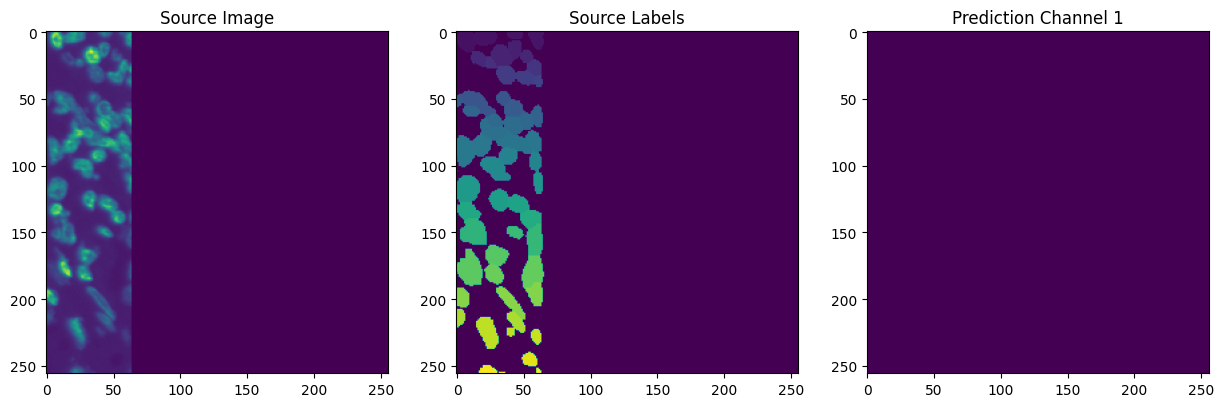

In [17]:
idx = 5
img, lab = X_test[idx].astype(np.float32), y_test[idx]
print(img.shape)
cpu_model = model.to("cpu")
cpu_model.device = "cpu"
pred = cpu_model.predict(np.expand_dims(img, axis=0), len(img))
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(lab[ ..., 0])
axes[1].set_title('Source Labels')

axes[2].imshow(cell_preds[idx, ...])
axes[2].set_title('Prediction Channel 1')

plt.show()

In [18]:
print(cell_preds.shape)

(10, 256, 256, 1)


In [19]:
print(lab.shape)

(256, 256, 2)


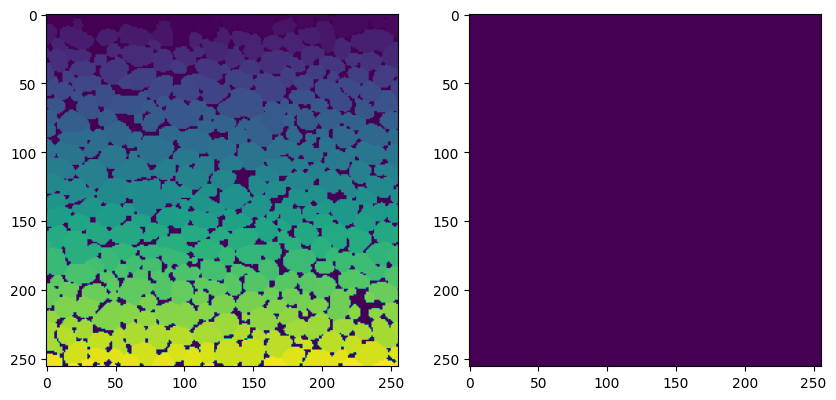

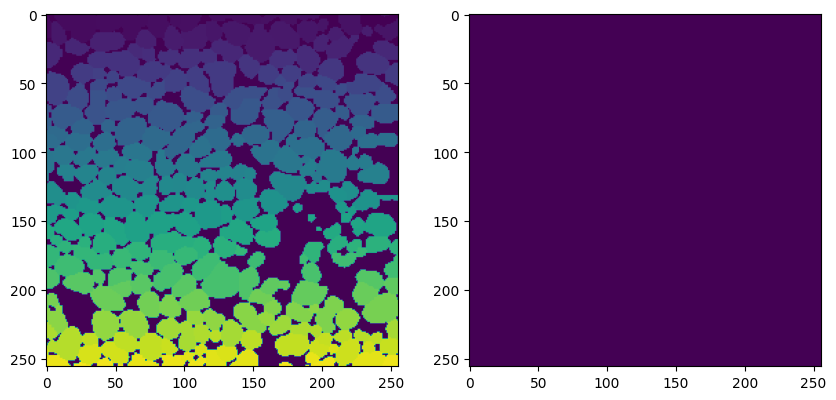

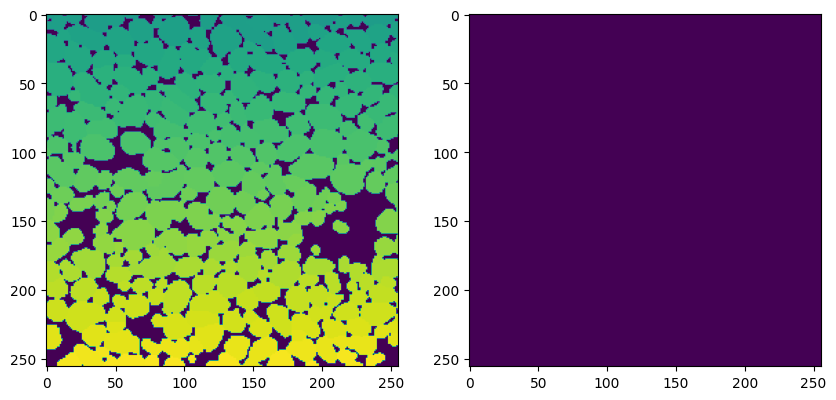

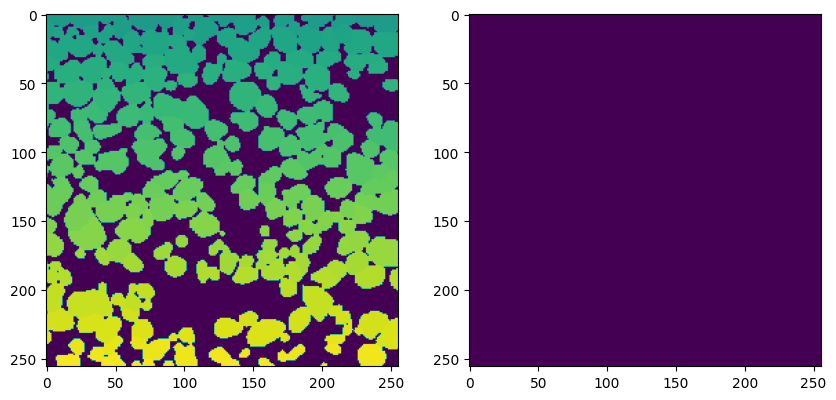

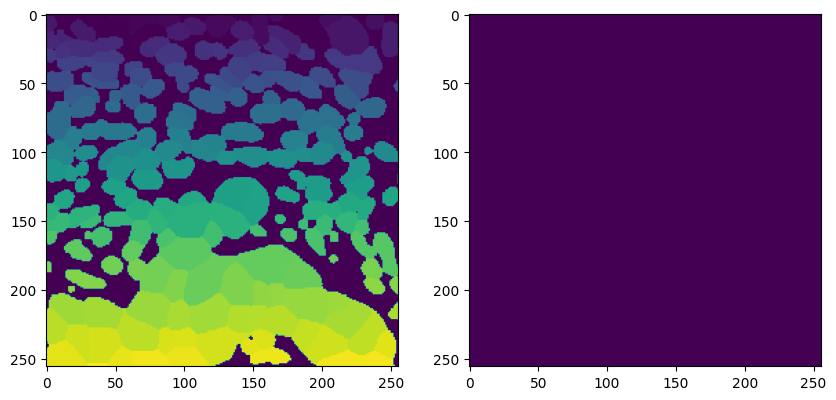

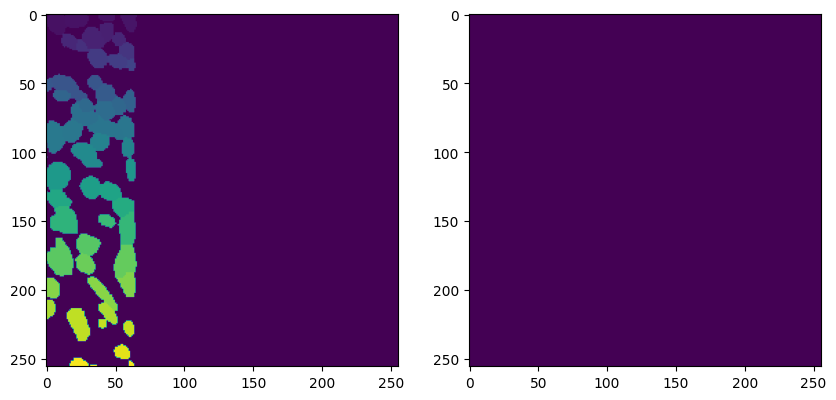

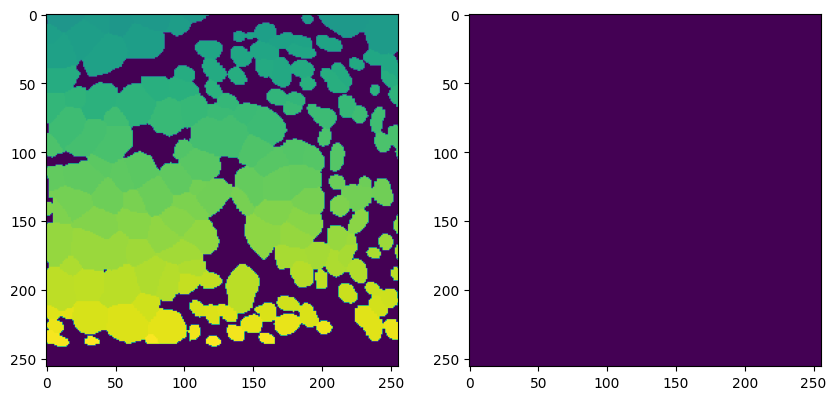

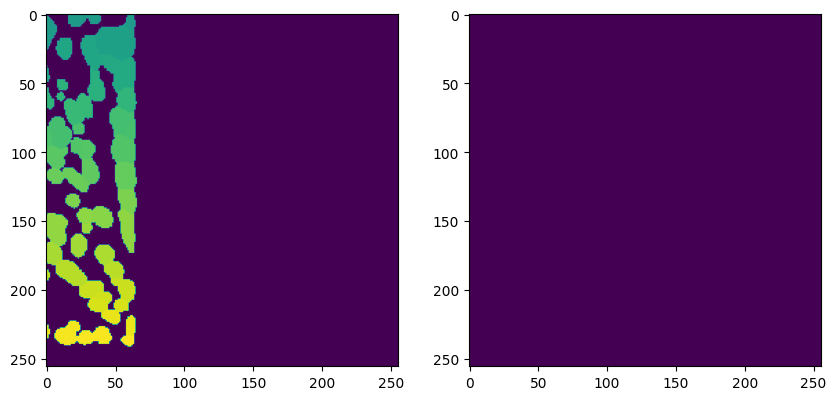

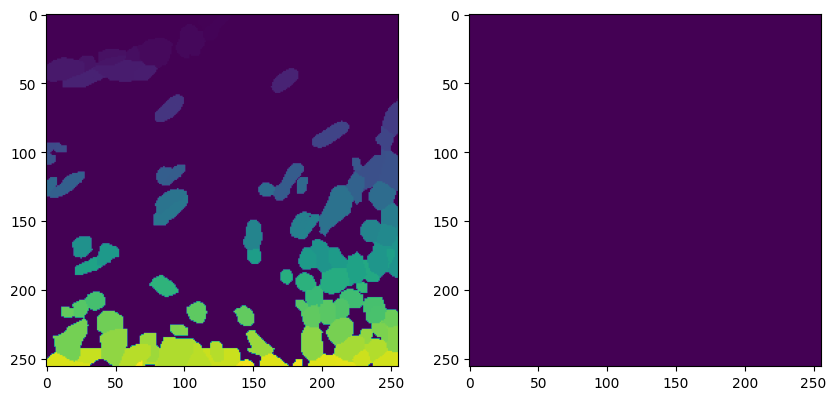

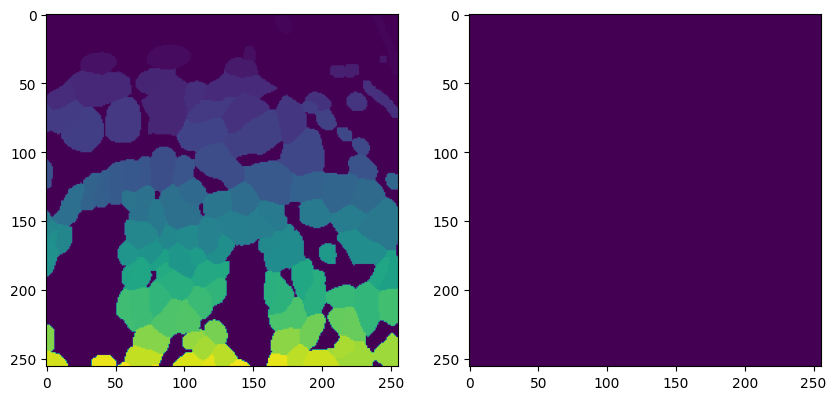

In [22]:
for i in range(len(cell_preds)):
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    axes[0].imshow(y_test[i, ..., 0])
    axes[1].imshow(cell_preds[i, ...])
    plt.show()